# This script is used to explore flow events.

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mannwhitneyu
# from brokenaxes import brokenaxes
import matplotlib.dates as mdates
import datetime

# Import local functions
from functions import plot_storm_cq
from functions import CQModel

In [3]:
# Define dir and site
site = '212058'
fig_dir = f'../output/figs/{site}/'
date_postfire = pd.to_datetime('2020-01-01')
date_postyear = pd.to_datetime('2021-06-30')
date_preyear = pd.to_datetime('2016-07-01')
freq = 'Hourly'
font_size = 14
Q_thre = 1

## 1 Data processing and formating

In [4]:
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'all', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True, format = "%H:%M:%S %d/%m/%Y" )
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(output_fn, index_label='id')

## 2. Plots show start of postfire for each catchment.

### 2.1 Plot for 212058

Text(0.8, 0.8, 'Postfire')

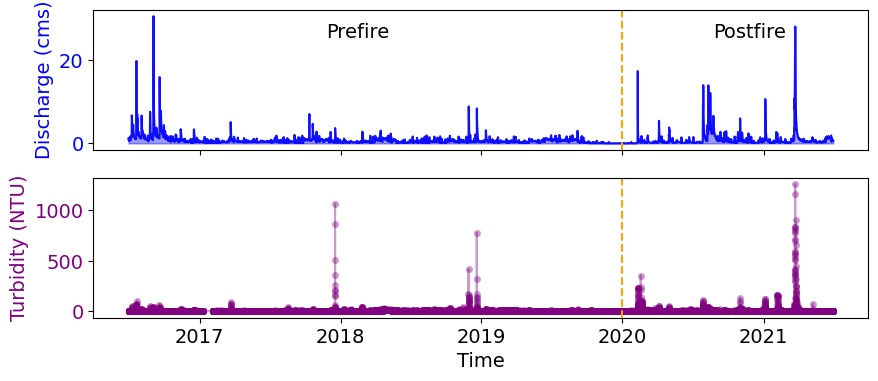

In [5]:
# Set up the figre and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="mixed", dayfirst=True)
cq_plot = cq_data[(cq_data['Datetime'] <= date_postyear) & (cq_data['Datetime'] >= date_preyear)]
# cq_plot = cq_data
cols = cq_plot.columns
# Adding a title
# plt.title(f'Flow and Turbidity @{site}', fontsize = font_size)
# Plot discharge using Seaborn
ax = sns.lineplot(x=cols[0], y=cols[-1], data=cq_plot, color='blue', alpha=0.9, ax=axes[0])
# Fill the area below the line
ax.fill_between(cq_plot[cols[0]], cq_plot[cols[-1]], color='blue',  alpha=0.4)
ax.set_ylabel(cols[-1], color='blue', fontsize = font_size)
ax.tick_params(axis='y', labelcolor='blue', labelsize = font_size)
# ax.set_yscale('log')
# ax.set_ylim(0.01, 1e3)

# Plot Turbidity in subplot 2 using Seaborn
sns.lineplot(x=cols[0], y=cols[2], data=cq_plot, ax=axes[1], color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.4, markersize = 5)
axes[1].set_ylabel(cols[2], color='purple', fontsize = font_size)
axes[1].tick_params(axis='y', labelcolor='purple', labelsize = font_size)
axes[1].tick_params(axis='x', labelsize = font_size)
axes[1].set_xlabel('Time', fontsize = font_size)
# ax.set_yscale('log')
# Add a horizontal line at a specific y-value (for example, y = 5)
ax.axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
axes[1].axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
plt.text(0.3, 0.8, 'Prefire', transform=ax.transAxes, fontsize = font_size)
plt.text(0.8, 0.8, 'Postfire', transform=ax.transAxes, fontsize = font_size)

# Show the plot
# plt.savefig(f'../output/figs/{site}/{site}_{freq}_CQ_whole_timeseries_log.png', bbox_inches = 'tight', dpi=300, format = 'png')

## 3-1 Explore C-Q for pre and post fire periods

In [6]:
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
storm_data = storm_data[(storm_data['Datetime'] <= date_postyear) & (storm_data['Datetime'] >= date_preyear)]
site = 212058
x_lab = cols[3]
y_lab = cols[2]
storm_data.drop_duplicates('Datetime', inplace=True)

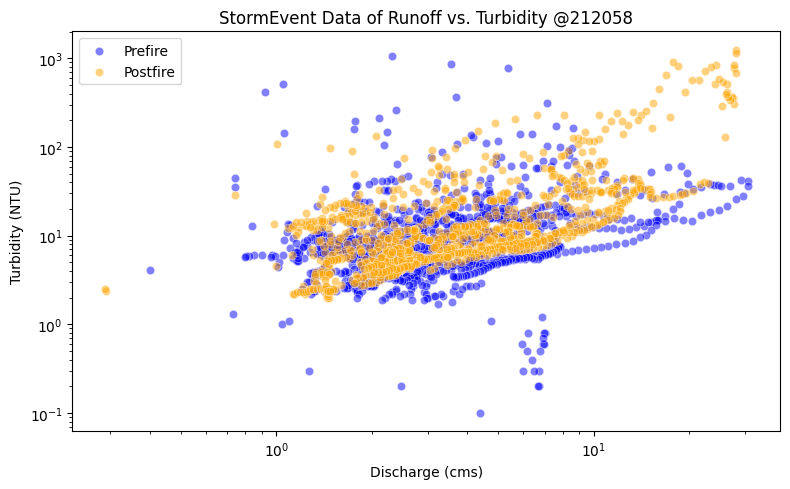

In [7]:
# Scatter plot
plot_storm_cq(storm_data, x_lab, y_lab, freq, site, date_postfire, Q_thre, colors = ['blue', 'orange'], marker='o', \
                  alpha = 0.5, labels = ['Prefire', 'Postfire'])

## 3-2 Plot hysteresis index 

In [8]:
# Select six events of the max peak flow during each periods accroding to QAbove_1_212058_StormEventClean
# import data
hys_fn = 'QAbove_1_212058_StormEventClean.csv'
hys_df = pd.read_csv(f'../output/CQ_analysis/{site}/' + hys_fn, index_col='id')
hys_df['start'] = pd.to_datetime(hys_df['start'], format='mixed', dayfirst=True)
hys_df['end'] = pd.to_datetime(hys_df['end'], format='mixed', dayfirst=True)
pre_hys = hys_df[(hys_df['end'] < date_postfire) & (hys_df['start'] >= date_preyear)].dropna()
post_hys = hys_df[(hys_df['start'] >= date_postfire) & (hys_df['end'] <= date_postyear)].dropna()

# Select six events of the max peak flow during each periods
six_events = [pre_hys['q_peak'].nlargest(6).index, post_hys['q_peak'].nlargest(6).index]
six_eventID_int = [[pre_hys.loc[ii, :].stormID for ii in six_events[0]], [post_hys.loc[jj, :].stormID for jj in six_events[1]]]
six_eventID = six_eventID_int.copy()
six_eventID_int = np.array(six_eventID_int)
six_eventID_int[0].sort()
six_eventID_int[1].sort()
six_eventID[0] = list(map(str, six_eventID_int[0]))
six_eventID[1] = list(map(str, six_eventID_int[1]))
six_eventID_int = six_eventID_int.astype('int64')

In [9]:
# import data
hys_fn = 'HysteresisEventClean.csv'
hys_df = pd.read_csv(f'../output/CQ_analysis/{site}/' + hys_fn, index_col='id')
hys_df['start'] = pd.to_datetime(hys_df['start'], format='mixed', dayfirst=True)
hys_df['end'] = pd.to_datetime(hys_df['end'], format='mixed', dayfirst=True)
hys_df.flsh_index = hys_df.flsh_index.round(2)
hys_df.stormID = hys_df.stormID.astype('str')
pre_hys = hys_df[(hys_df['end'] < date_postfire) & (hys_df['start'] >= date_preyear)].dropna()
post_hys = hys_df[(hys_df['start'] >= date_postfire) & (hys_df['end'] <= date_postyear)].dropna()

### 3-3 Histplot of Flush Index for pre and post fire

C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\3145658469.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.arange(1, 7))
C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\3145658469.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(np.arange(1, 7))


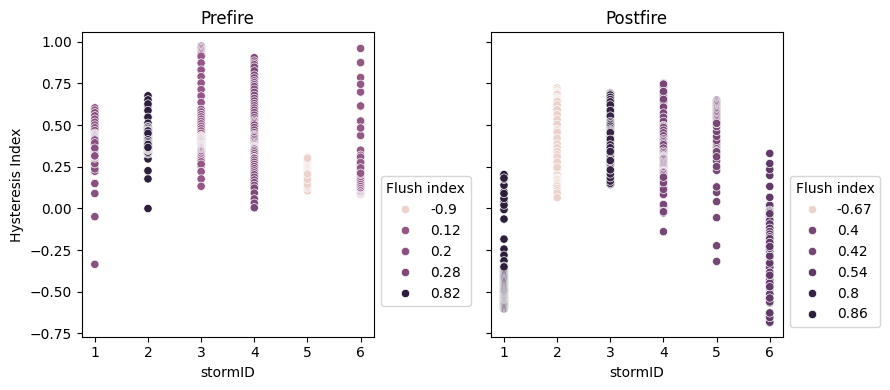

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharex=False, sharey=True)
# 调整子图之间的横向距离，增加间距
plt.subplots_adjust(wspace=0.4) 
data_temp = pd.DataFrame()
for jj in six_eventID[0]:
    data_temp = pd.concat([data_temp, pre_hys[pre_hys['stormID'] == jj]])
sns.scatterplot(data=data_temp, x='stormID', y='hyst_index', \
                hue='flsh_index', ax=axes[0])
# axes[0].set_xticks((six_eventID[0]))
axes[0].set_xticklabels(np.arange(1, 7))
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 0.55), title='Flush index')
axes[0].set_ylabel('Hysteresis Index')
axes[0].set_title('Prefire')
# Plot postfire period
data_temp = pd.DataFrame()
for jj in six_eventID[1]:
    data_temp = pd.concat([data_temp, post_hys[post_hys.stormID == jj]])
sns.scatterplot(data=data_temp, x='stormID', y='hyst_index', \
                hue='flsh_index', ax=axes[1])
# axes[1].set_xticks(six_eventID[1])
axes[1].set_xticklabels(np.arange(1, 7))
axes[1].set_title('Postfire')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 0.55), title='Flush index')
plt.tight_layout()
# plt.savefig(f'{fig_dir}HystFlshIndexScatter.png', format = 'png', dpi=300)

### 3-4 Plot hysteresis for 6 events before and after bushfire

In [10]:
# Calculate the CV_c/CV_q for all events
# Read storm event data
cv_df = pd.read_csv('../output/CQ_analysis/212058/CV_flow_tbdt.csv')
cv_prefire = cv_df[cv_df['stormID'].isin(six_eventID_int[0])]
cv_postfire = cv_df[cv_df['stormID'].isin(six_eventID_int[1])]

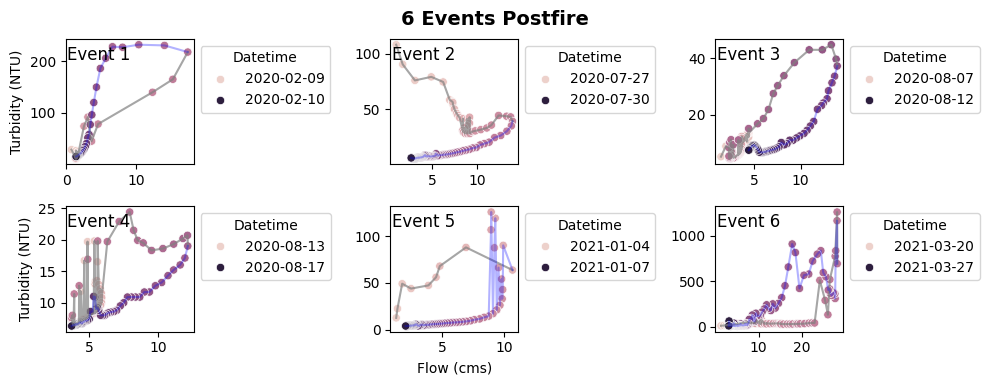

In [ ]:
# Select 6 events before and after fire
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + \
                        f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', \
                        index_col = 'id')
# Set stormID to str format
# Select six events of the max peak flow during each periods
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10, 4))
title = ['6 Events Prefire', '6 Events Postfire'][1]
dt_plot = six_eventID_int[1] # six_eventID[1] for postfire events and six_eventID[0] for prefire events
kk = 0
# Plot the normalized flow and turbidity if norm_plot = True;
# Otherwise, plot the absolute values of flow and turbidity
norm_plot = False
if norm_plot:
    xx = 'norm_tot_q'; yy = 'norm_c'
    xlab = 'Normalized flow'; ylab = 'Normalized Turbidity'
else:
    xx = 'total_flow'; yy = 'Turbidity (NTU)'
    xlab = 'Flow (cms)'; ylab = yy
for ii in range(2):
    for jj in range(3):
        # Simplified condition for legend
        # lgnd = kk == 5
        lgnd = True
        hys_temp = storm_data[storm_data['stormID'] == float(dt_plot[kk])]
        cvcq = cv_df.loc[(cv_df['stormID'] == float(dt_plot[kk])), 'cvcq_total'].values[0]
        peak_idx = hys_temp['norm_tot_q'].idxmax()
        # Plot the hysteresis for each period
        sns.scatterplot(hys_temp, x = xx, y =yy, hue='norm_ts', \
                        ax = axes[ii, jj], legend=lgnd)
        sns.lineplot(hys_temp.loc[:peak_idx, :], x = xx, y =yy, \
                        ax = axes[ii, jj], legend=lgnd, color='grey', alpha=0.7)
        sns.lineplot(hys_temp.loc[peak_idx:, :], x = xx, y =yy, \
                        ax = axes[ii, jj], legend=lgnd, color='blue', alpha=0.3)
        # Set event ID as title
        axes[ii, jj].set_title(f'Event {kk + 1}', loc='center', pad=12, x=0.26, y=0.7)
        # axes[ii, jj].text(0.05, 0.7, r'$CV_c/CV_q = {:.2f}$'.format(cvcq), transform=axes[ii, jj].transAxes)
        # Creating a custom legend with absolute time for each subplot
        handles, labels = axes[ii, jj].get_legend_handles_labels()
        # Create custom legend labels: only include the first and last absolute time
        custom_labels = [str(hys_temp.Datetime.values[0][0:10]), str(hys_temp.Datetime.values[-1][0:10])]
        # Set the new legend with the custom labels
        axes[ii, jj].legend([handles[0], handles[-1]], custom_labels, title="Datetime", 
                            loc='upper left', bbox_to_anchor=(1., 1))
        kk += 1
        #Set subplot's xlabel to none
        axes[ii, jj].set_xlabel('')
    # Set labels
    axes[ii, 0].set_ylabel(ylab)
    axes[ii, 1].set_ylabel('')
    axes[ii, 2].set_ylabel('')

axes[1, 1].set_xlabel(xlab)
plt.suptitle(title, fontsize=font_size, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=0.02, hspace=0.05) 
# axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.tight_layout()
# plt.savefig(f'{fig_dir}{title}HysteresisNorm{norm_plot}.png', format='png', dpi=300)

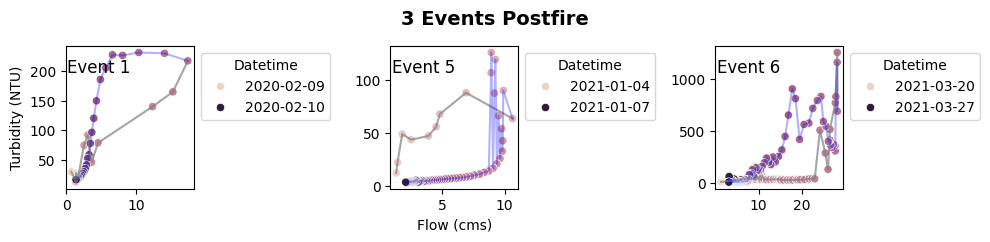

In [25]:
# Select 3 events before and after fire
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + \
                        f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', \
                        index_col = 'id')
# Set stormID to str format
# Select six events of the max peak flow during each periods
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(10, 2.5))
title = ['3 Events Prefire', '3 Events Postfire'][1]
dt_plot = [six_eventID_int[1][0], six_eventID_int[1][4], six_eventID_int[1][5]] # six_eventID[1] for postfire events and six_eventID[0] for prefire events
kk = [1, 5, 6]
# Plot the normalized flow and turbidity if norm_plot = True;
# Otherwise, plot the absolute values of flow and turbidity
norm_plot = False
if norm_plot:
    xx = 'norm_tot_q'; yy = 'norm_c'
    xlab = 'Normalized flow'; ylab = 'Normalized Turbidity'
else:
    xx = 'total_flow'; yy = 'Turbidity (NTU)'
    xlab = 'Flow (cms)'; ylab = yy
for jj in range(3):
    # Simplified condition for legend
    # lgnd = kk == 5
    lgnd = True
    hys_temp = storm_data[storm_data['stormID'] == float(dt_plot[jj])]
    cvcq = cv_df.loc[(cv_df['stormID'] == float(dt_plot[jj])), 'cvcq_total'].values[0]
    peak_idx = hys_temp['norm_tot_q'].idxmax()
    # Plot the hysteresis for each period
    sns.scatterplot(hys_temp, x = xx, y =yy, hue='norm_ts', \
                    ax = axes[jj], legend=lgnd)
    sns.lineplot(hys_temp.loc[:peak_idx, :], x = xx, y =yy, \
                    ax = axes[jj], legend=lgnd, color='grey', alpha=0.7)
    sns.lineplot(hys_temp.loc[peak_idx:, :], x = xx, y =yy, \
                    ax = axes[jj], legend=lgnd, color='blue', alpha=0.3)
    # Set event ID as title
    axes[jj].set_title(f'Event {kk[jj]}', loc='center', pad=12, x=0.26, y=0.7)
    # axes[ii, jj].text(0.05, 0.7, r'$CV_c/CV_q = {:.2f}$'.format(cvcq), transform=axes[ii, jj].transAxes)
    # Creating a custom legend with absolute time for each subplot
    handles, labels = axes[jj].get_legend_handles_labels()
    # Create custom legend labels: only include the first and last absolute time
    custom_labels = [str(hys_temp.Datetime.values[0][0:10]), str(hys_temp.Datetime.values[-1][0:10])]
    # Set the new legend with the custom labels
    axes[jj].legend([handles[0], handles[-1]], custom_labels, title="Datetime", 
                        loc='upper left', bbox_to_anchor=(1., 1))
    #Set subplot's xlabel to none
    axes[jj].set_xlabel('')
# Set labels
axes[0].set_ylabel(ylab)
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[1].set_xlabel(xlab)
plt.suptitle(title, fontsize=font_size, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=0.02, hspace=0.05) 
# axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.tight_layout()
plt.savefig(f'{fig_dir}{title}HysteresisNorm_3events{norm_plot}.png', format='png', dpi=300)

# Generate illustrative hysteresis plot

In [36]:
def mix_model(flow, aq, bq, ab, bb, n=4):
        """
        flow: of shape (1, 3) with the first column as total flow, the second as quick and the last as base.
        coeff: {'aq', 'bq', 'ab', 'bb'}
        n: the fixed value for calibrating coeff. The default value is 10.
        """
        # aq, bq, ab, bb = coeff
        q_total, q_quick, q_base = flow[0, :], flow[1, :], flow[2, :]
        assert flow.shape[0] == 3, 'Flow should contain total storm flow, base, and quick flow.'   
        c_quick = np.power((aq + bq * (q_quick ** 1/n)), n) * q_quick / q_total
        c_base = np.power((ab + bb * (q_base ** 1/n)), n) * q_base / q_total
        conc = c_quick + c_base
        return conc

In [37]:
# Select 9 events before and after fire
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + \
                        f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', \
                        index_col = 'id')
storm_data.reindex()
# Calculate turbidity
flow = np.array([storm_data['Discharge (cms)'].values, 
                 storm_data['storm_flow'].values, storm_data['base_flow'].values])
storm_data['turb_est'] = mix_model(flow, 1.90, 0.27, 0.62, 0.91, n=4)
# Normalize concentration and flow
for grp_id, stm in storm_data.groupby('stormID'):
    storm_data.loc[stm.index, 'sim_norm_turb'] = (stm['turb_est'] - stm['turb_est'].min()) \
                                        / (stm['turb_est'].max() - stm['turb_est'].min())

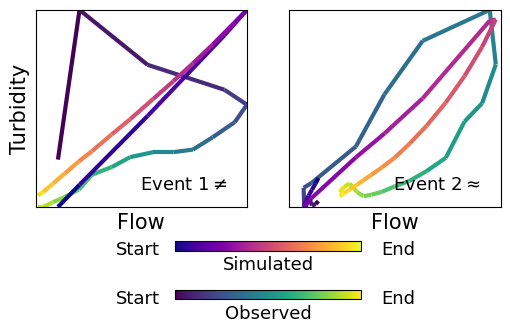

In [43]:
# Set stormID to str format
# Select six events of the max peak flow during each periods
from matplotlib.collections import LineCollection
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(6, 4))
plt.rcParams.update({
    'font.size':        13,               # 控制默认文本大小
    'axes.titlesize':   13,          # 坐标轴标题大小
    'axes.labelsize':   13,          # 坐标轴标签大小
    'xtick.labelsize':  13,         # x轴刻度标签大小
    'ytick.labelsize':  13,         # y轴刻度标签大小
    'legend.fontsize':  13,         # 图例字体大小
    'figure.titlesize': 13         # 图形总标题大小
})
# Plot the normalized flow and turbidity if norm_plot = True;
# Otherwise, plot the absolute values of flow and turbidity
norm_plot = True
if norm_plot:
    xx = 'norm_tot_q'; yy = 'norm_c'
    xlab = 'Flow'; ylab = 'Turbidity'
else:
    xx = 'total_flow'; yy = 'Turbidity (NTU)'
    xlab = 'Flow (cms)'; ylab = yy
lgnd = False

hys_storm1 = storm_data[storm_data['stormID'] == float(six_eventID_int[0][3])]
hys_storm2 = storm_data[storm_data['stormID'] == float(six_eventID_int[1][2])]
peak_idx = [hys_storm1['norm_tot_q'].idxmax(), hys_storm2['norm_tot_q'].idxmax()]
for ax, peak, idx, event in zip(axes, peak_idx, [1, 2], [hys_storm1, hys_storm2]):
    # Plot the hysteresis for each period using observed turbidity
    if idx == 2:
        event = event.iloc[30:]
    event = event.iloc[::3]
    # plot observation
    points = np.array([event['norm_tot_q'].values, event['norm_c'].values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    norm = plt.Normalize(event['norm_ts'].values.min(), event['norm_ts'].values.max())
    lc = LineCollection(segments, cmap = 'viridis', norm = norm)
    lc.set_array(event['norm_ts'].values)
    lc.set_linewidths(3)
    line = ax.add_collection(lc)
    
    # Plot simulation
    points_sim = np.array([event['norm_tot_q'].values, event['sim_norm_turb'].values]).T.reshape(-1, 1, 2)
    segments_sim = np.concatenate([points_sim[:-1], points_sim[1:]], axis = 1)
    norm_sim = plt.Normalize(event['norm_ts'].values.min(), event['norm_ts'].values.max())
    lc_sim = LineCollection(segments_sim, cmap = 'plasma', norm = norm_sim)
    lc_sim.set_array(event['norm_ts'].values)
    lc_sim.set_linewidths(3)
    line_sim = ax.add_collection(lc_sim)
    # Set event ID as title
    # Creating a custom legend with absolute time for each subplot
    ax.set_xlabel(xlab)
    # 隐藏刻度线和坐标
    ax.set_xticks([])
    ax.set_yticks([])
    # Set labels
axes[0].set_ylabel(ylab)
axes[1].set_ylabel('')
axes[0].set_title(r'Event 1$ \neq $', loc='center', pad=12, x=0.7, y=0.0)
axes[1].set_title(r'Event 2$ \approx $', loc='center', pad=12, x=0.7, y=0.0)
# 添加 colorbar（隐藏默认标签）
cbar = fig.colorbar(line, ticks=[], orientation='horizontal', shrink=0.4, ax=[axes[0], axes[1]], anchor=(0.5, 0.5), pad=0.05)
# 在 colorbar 的底部和顶部添加自定义文本
cbar.ax.text(-0.2, 0.1, 'Start', 
             ha='center', va='center', transform=cbar.ax.transAxes)
cbar.ax.text(1.2, 0.1, 'End',
             ha='center', va='center', transform=cbar.ax.transAxes)
cbar.set_label('Observed')

# 添加模拟值的coloarbar
cbar_sim = fig.colorbar(line_sim, ticks=[], orientation='horizontal', shrink=0.4, ax=[axes[0], axes[1]], anchor=(0.5, 0.2), pad=0.05)
# 在 colorbar 的底部和顶部添加自定义文本
cbar_sim.ax.text(-0.2, 0.1, 'Start', 
             ha='center', va='center', transform=cbar_sim.ax.transAxes)
cbar_sim.ax.text(1.2, 0.1, 'End',
             ha='center', va='center', transform=cbar_sim.ax.transAxes)
cbar_sim.set_label('Simulated')

# plt.subplots_adjust(wspace=0.01) 
# plt.tight_layout()
plt.savefig(f'{fig_dir}Illustrative plot/HysteresisNorm{norm_plot}.png', format='png', dpi=300)

Create illustrative plot -- cumulative distribution plot

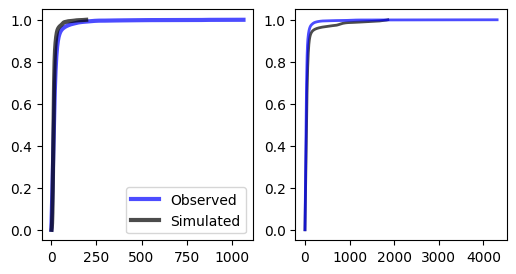

In [15]:
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid  
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'], format = 'mixed', dayfirst = True)
storm_data['Time Period'] = storm_data['Datetime'].apply(
    lambda x: 'Postfire' if x > date_postfire else 'Prefire')
# 用KDE估计概率密度函数（PDF）
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(6, 3))
# Plot prefire data
prefire_data = storm_data[storm_data['Time Period'] == 'Prefire']
postfire_data = storm_data[storm_data['Time Period'] == 'Postfire']
for color, ls, data, label in zip(['blue', 'black'], ['-', '--'], 
                                  [prefire_data['Turbidity (NTU)'].values, prefire_data['turb_est'].values],
                                  ['Observed', 'Simulated']):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)  # 精细网格
    pdf = kde.evaluate(x_grid)

    # 数值积分PDF得到CDF（累积分布函数）
    cdf = cumulative_trapezoid(pdf, x_grid, initial=0)
    cdf = cdf / cdf[-1]  # 归一化到[0, 1]
    # 绘制平滑CDF曲线
    axes[0].plot(x_grid, cdf, color=color, ls = '-', lw=3, label=label, alpha = 0.7)
axes[0].legend()
# Plot postfire data
for color, ls, data, label in zip(['black', 'blue'], ['-.-', '-'], 
                                  [postfire_data['Turbidity (NTU)'].values, postfire_data['turb_est'].values],
                                  ['Observed', 'Simulated']):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)  # 精细网格
    pdf = kde.evaluate(x_grid)

    # 数值积分PDF得到CDF（累积分布函数）
    cdf = cumulative_trapezoid(pdf, x_grid, initial=0)
    cdf = cdf / cdf[-1]  # 归一化到[0, 1]
    # 绘制平滑CDF曲线
    axes[1].plot(x_grid, cdf, color=color, ls = '-', lw=2, label=label, alpha = 0.7)

## 4 Plot simulated Turbidity by CQ models

### 4-1 Observations transformed by different n values

n = 1: R² score: 0.2232733623551616
n = 2: R² score: 0.262465298926266
n = 4: R² score: 0.27116721135186983
n = 6: R² score: 0.26763653792645103
n = 15: R² score: 0.24802019836480305


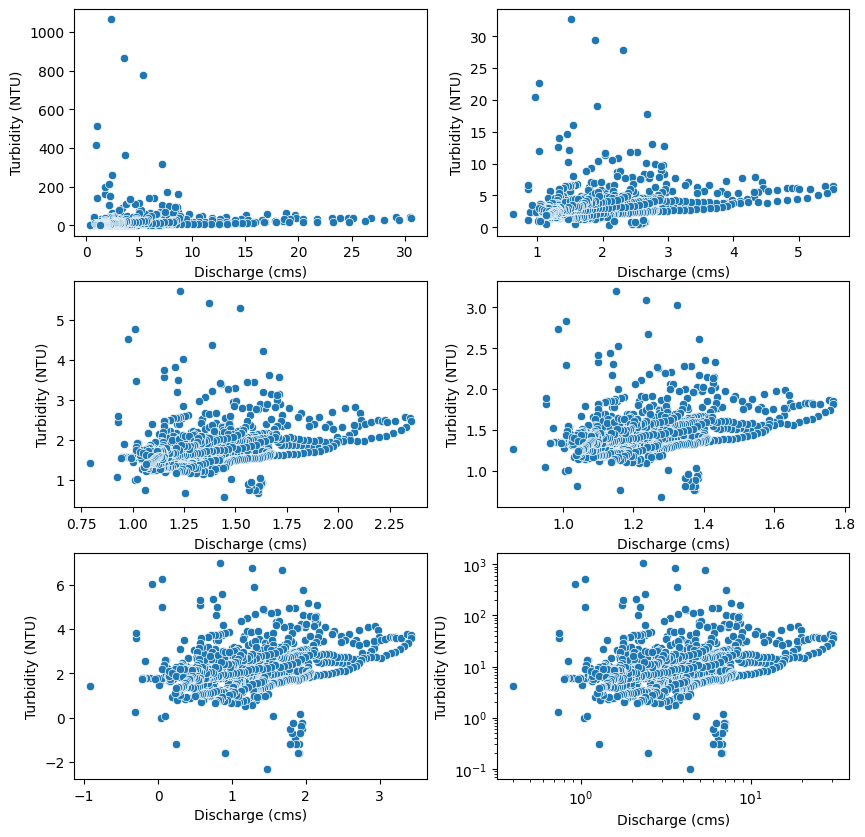

In [16]:
## Explore the relationship in 1/n space
# Read storm event data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
freq = 'Hourly'
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'Q_above_1_212058_StormEventRefilterData.csv', index_col='id')
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
storm_data = storm_data[(storm_data['Datetime'] <= date_postyear) & (storm_data['Datetime'] >= date_preyear)]
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'], format='mixed', dayfirst=True)
x_lab = cols[3]
y_lab = cols[2]
data_copy = storm_data.copy()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 10))
kk = 0
test_n = [1, 2, 4, 6, 15]
for ii in range(3):
    for jj in range(2):
        if kk <= 4:
            n = test_n[kk]
            data_copy.loc[:, x_lab] = np.power(storm_data.loc[:, x_lab], 1/n)
            data_copy.loc[:, y_lab] = np.power(storm_data.loc[:, y_lab], 1/n)
            if n == 15:
                data_copy.loc[:, x_lab] = np.log(storm_data.loc[:, x_lab])
                data_copy.loc[:, y_lab] = np.log(storm_data.loc[:, y_lab])
            # 创建线性回归模型实例
            model = LinearRegression()
            
            # 拟合模型
            x = data_copy.loc[:, x_lab].values.reshape(2250, 1)
            y = data_copy.loc[:, y_lab].values.reshape(2250, 1)
            model.fit(x,y)
            # 使用r2_score计算R²值
            y_pred = model.predict(x)  # 预测值
            r2 = r2_score(y, y_pred)   # 计算R²值

            print(f'n = {n}: R² score: {r2}')
            data_copy.drop_duplicates('Datetime', inplace=True)
            # Scatter plot
            kk += 1
            sns.scatterplot(x=x_lab, y=y_lab, data=data_copy[data_copy.Datetime < date_postfire], ax=axes[ii, jj])
        else:
            sns.scatterplot(x=x_lab, y=y_lab, data=storm_data[storm_data.Datetime < date_postfire], ax=axes[ii, jj])
            ax=axes[ii, jj].set_xscale('log')
            ax=axes[ii, jj].set_yscale('log')
# plt.savefig(f'{fig_dir}test_n.png', format = 'png', dpi=300)

### 4-2 Create boxplot of residuals from different models

In [17]:
# Calculate residuals by different CQ models
storm_data.dropna(inplace=True)
storm_data['Residual_power'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_power_precal']
storm_data['Residual_mix_precal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Precal']
storm_data['Residual_mix_postcal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Postcal']
storm_data['Residual_mix_fullcal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Fullcal']
condtn = [storm_data[storm_data['Datetime'] < date_postfire], storm_data[storm_data['Datetime'] >= date_postfire]]
# Boxplot showing residuals
resdl = storm_data.filter(storm_data.columns[-9:])
resdl['Time Period'] = storm_data['Time Period']
resdl_long = resdl.melt(id_vars=['Time Period', 'Est_Tbdt_mix_Precal', 'Est_Tbdt_mix_Postcal', 'Est_Tbdt_mix_Fullcal'], \
           var_name='CQmodel Type', value_name='Residual')
# Apply log transformation to positive values only
resdl_long['Residual_log'] = np.where(resdl_long['Residual'] > 0, np.log(resdl_long['Residual']), resdl_long['Residual'])

c:\Users\u1066632\AppData\Local\anaconda3\envs\bushfire_wq\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [133]:
storm_data.head()

,Datetime,Discharge (ML/d),Turbidity (NTU),Discharge (cms),stormID,stormCount,base_flow,storm_flow,total_flow,norm_tot_q,...,norm_ts,Time Period,Est_Tbdt_power_precal,Est_Tbdt_mix_Precal,Est_Tbdt_mix_Postcal,Est_Tbdt_mix_Fullcal,Residual_power,Residual_mix_precal,Residual_mix_postcal,Residual_mix_fullcal
id,,,,,,,,,,,,,,,,,,,,,
57137,2016-07-08 18:00:00,172.510,13.8,1.997,20,21,1.305570,0.691430,1.997,0.000000,...,0.000000,Prefire,14.793979,15.932893,6.867687,9.955821,-0.993979,-2.132893,6.932313,3.844179
57138,2016-07-08 19:00:00,232.642,9.7,2.693,20,21,1.311272,1.381728,2.693,0.146372,...,0.023810,Prefire,16.135892,16.366254,8.587663,11.644689,-6.435892,-6.666254,1.112337,-1.944689
57139,2016-07-08 20:00:00,264.156,15.8,3.057,20,21,1.317806,1.739194,3.057,0.222923,...,0.047619,Prefire,16.740982,16.596386,9.606339,12.609087,-0.940982,-0.796386,6.193661,3.190913
57140,2016-07-08 21:00:00,278.065,40.3,3.218,20,21,1.325473,1.892527,3.218,0.256782,...,0.071429,Prefire,16.992357,16.698946,10.084702,13.054233,23.307643,23.601054,30.215298,27.245767
57141,2016-07-08 22:00:00,287.244,49.9,3.325,20,21,1.334378,1.990622,3.325,0.279285,...,0.095238,Prefire,17.154522,16.767369,10.412355,13.356525,32.745478,33.132631,39.487645,36.543475


In [141]:
# Calculate NSE and PBIAS
from spotpy.objectivefunctions import nashsutcliffe, pbias, rrmse
perf_dict = {'NSE_prefire':[], 'NSE_postfire': [], 'Pbias_prefire':[], 'Pbias_postfire': []}
for model in ['Est_Tbdt_mix_Precal', 'Est_Tbdt_mix_Postcal', 'Est_Tbdt_mix_Fullcal']:
    # Performance during prefire periods
    turb_est = storm_data[storm_data['Time Period'] == 'Prefire']
    perf_dict['NSE_prefire'].append(nashsutcliffe(turb_est['Turbidity (NTU)'], turb_est[model]))
    perf_dict['Pbias_prefire'].append(pbias(turb_est['Turbidity (NTU)'], turb_est[model]))
    # Performance during postfire periods
    turb_est_post = storm_data[storm_data['Time Period'] == 'Postfire']
    perf_dict['NSE_postfire'].append(nashsutcliffe(turb_est_post['Turbidity (NTU)'], turb_est_post[model]))
    perf_dict['Pbias_postfire'].append(pbias(turb_est_post['Turbidity (NTU)'], turb_est_post[model]))
perf_df = pd.DataFrame.from_dict(perf_dict, orient='index', columns=['Est_Tbdt_mix_Precal', 'Est_Tbdt_mix_Postcal', 'Est_Tbdt_mix_Fullcal'])
perf_df.to_csv(f'../output/figs/{site}/power-law_model_performance.csv')

### 4-3 Timeseries plot of obs and CQ modelled turbidity

In [18]:
## Plot time series of the six selected events
# Filter the six events of high magnitude
event_pre = storm_data[storm_data['stormID'].isin(six_eventID_int[0])]
event_post = storm_data[storm_data['stormID'].isin(six_eventID_int[1])]
# Get the start and end time of each event 

In [19]:
start_time, end_time = [], []
start_date, end_date = [], []
for ii in range(2):
    for jj in range(6):
        t1 = storm_data[storm_data['stormID'] == six_eventID_int[ii][jj]]['Datetime'].values[0]
        t2 = storm_data[storm_data['stormID'] == six_eventID_int[ii][jj]]['Datetime'].values[-1]
        start_date.append(t1)
        end_date.append(t2)
        start_time.append(mdates.date2num(pd.Timestamp(t1)))
        end_time.append(mdates.date2num(pd.Timestamp(t2)))
# Create a list for start and end time of selected events, xlim_all
xlim_all = []
for ii in range(len(start_time)):
    xlim_all.append((start_time[ii], end_time[ii]))
xlim_all

[(np.float64(17002.375), np.float64(17006.791666666668)),
 (np.float64(17046.416666666668), np.float64(17050.041666666668)),
 (np.float64(17062.75), np.float64(17064.708333333332)),
 (np.float64(17065.791666666668), np.float64(17067.958333333332)),
 (np.float64(17863.375), np.float64(17865.666666666668)),
 (np.float64(17884.708333333332), np.float64(17887.041666666668)),
 (np.float64(18301.125), np.float64(18302.75)),
 (np.float64(18470.041666666668), np.float64(18473.875)),
 (np.float64(18481.875), np.float64(18486.25)),
 (np.float64(18487.291666666668), np.float64(18491.5)),
 (np.float64(18631.625), np.float64(18634.208333333332)),
 (np.float64(18706.583333333332), np.float64(18713.916666666668))]

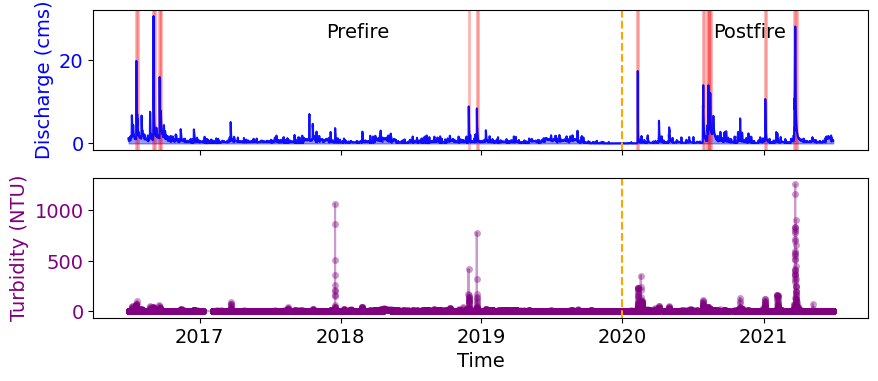

In [21]:
## Plot timeseries of obs data with windows highlighting the selected storm events
# Obtain start and end time of each storm events.
storm_windows = [
    (start_date[ii], end_date[ii], f'Storm {(ii % 6) + 1}') for ii in range(len(start_date))
    ]

# Set up the figre and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="mixed", dayfirst=True)
cq_plot = cq_data[(cq_data['Datetime'] <= date_postyear) & (cq_data['Datetime'] >= date_preyear)]
# cq_plot = cq_data
cols = cq_plot.columns
# Adding a title
# plt.title(f'Flow and Turbidity @{site}', fontsize = font_size)
# Plot discharge using Seaborn
ax = sns.lineplot(x=cols[0], y=cols[-1], data=cq_plot, color='blue', alpha=0.9, ax=axes[0])
# Fill the area below the line
ax.fill_between(cq_plot[cols[0]], cq_plot[cols[-1]], color='blue',  alpha=0.4)
ax.set_ylabel(cols[-1], color='blue', fontsize = font_size)
ax.tick_params(axis='y', labelcolor='blue', labelsize = font_size)
# ax.set_yscale('log')
# ax.set_ylim(0.01, 1e3)

# Plot Turbidity in subplot 2 using Seaborn
sns.lineplot(x=cols[0], y=cols[2], data=cq_plot, ax=axes[1], color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.4, markersize = 5)
axes[1].set_ylabel(cols[2], color='purple', fontsize = font_size)
axes[1].tick_params(axis='y', labelcolor='purple', labelsize = font_size)
axes[1].tick_params(axis='x', labelsize = font_size)
axes[1].set_xlabel('Time', fontsize = font_size)
# ax.set_yscale('log')
# Add a horizontal line at a specific y-value (for example, y = 5)
ax.axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
axes[1].axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
plt.text(0.3, 0.8, 'Prefire', transform=ax.transAxes, fontsize = font_size)
plt.text(0.8, 0.8, 'Postfire', transform=ax.transAxes, fontsize = font_size)


# Plot each storm event as shaded area + add annotation
for start, end, label in storm_windows:
    start_t = pd.to_datetime(start)
    end_t = pd.to_datetime(end)
    
    # Shade the storm window
    ax.axvspan(start_t, end_t, color='red', alpha=0.3, linewidth = 2)


# Show the plot
# plt.savefig(f'../output/figs/{site}/{site}_{freq}_CQ_whole_timeseries_log.png', bbox_inches = 'tight', dpi=300, format = 'png')

C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\1455358193.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_temp.set_xticklabels([formatted_ticks[0]] + [''] * (len(formatted_ticks) - 2) + [formatted_ticks[-1]],
C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\1455358193.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_temp.set_xticklabels([formatted_ticks[0]] + [''] * (len(formatted_ticks) - 2) + [formatted_ticks[-1]],
C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\1455358193.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_temp.set_xticklabels([formatted_ticks[0]] + [''] * (len(formatted_ticks) - 2) + [formatted_ticks[-1]],
C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\1455358193.py:35: UserWarn

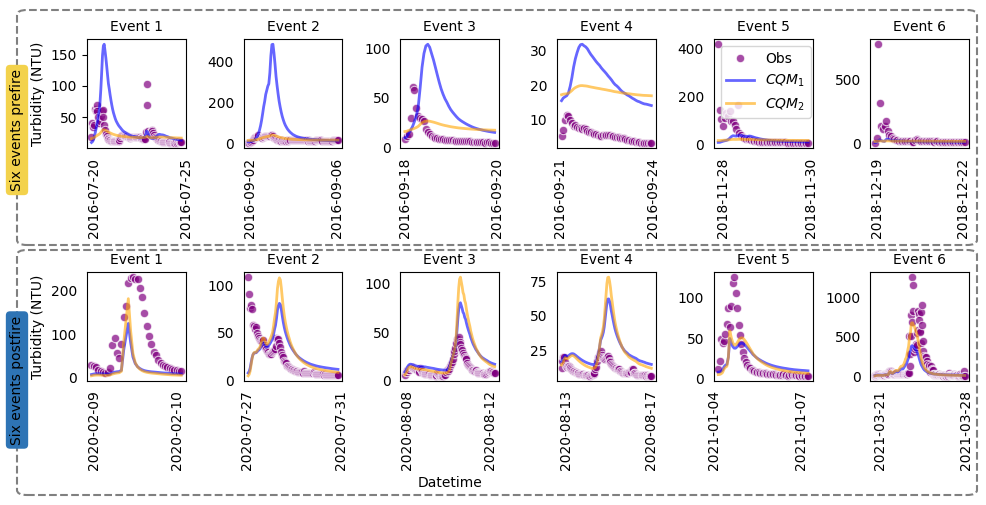

In [132]:
# Creat subplots for events
fig, axes = plt.subplots(2, 6, sharey = False, figsize = (10, 5))
kk = 0
for ii in range(2):
    for jj in range(6):
        if kk == 4:
            legend_tf = True
        else:
            legend_tf = False
        sub_data = storm_data[storm_data['stormID'] == six_eventID_int[ii][jj]]
        ax_temp = sns.lineplot(data = sub_data, x = 'Datetime', y = 'Turbidity (NTU)', ax = axes[ii][jj], label = 'Obs',
                               legend = legend_tf, color = 'purple', alpha = 0.7, linestyle='', marker='o')
        if ii == 0:
            sns.lineplot(data = sub_data, x = 'Datetime', y = 'Est_Tbdt_mix_Fullcal', color = 'blue', 
                        ax = axes[ii][jj], label = r'$CQM_{1}$', alpha = 0.6, legend=legend_tf, linewidth = 2)
            sns.lineplot(data = sub_data, x = 'Datetime', y='Est_Tbdt_mix_Precal', color = 'orange',
                        ax = axes[ii][jj],  alpha = 0.6, label = r'$CQM_{2}$', legend=legend_tf, linewidth = 2)
        else:
            sns.lineplot(data = sub_data, x = 'Datetime', y = 'Est_Tbdt_mix_Fullcal', color = 'blue', 
                        ax = axes[ii][jj], label = r'$CQM_{1}$', alpha = 0.6, legend=legend_tf, linewidth = 2)
            sns.lineplot(data = sub_data, x = 'Datetime', y='Est_Tbdt_mix_Postcal', color = 'orange',
                        ax = axes[ii][jj],  alpha = 0.6, label = r'$CQM_{2}$', legend=legend_tf, linewidth = 2)
        kk += 1
        if kk > 1:
            ax_temp.yaxis.set_ticks_position('none')
        # Format the x-axis for datetime
        ax_temp.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax_temp.xaxis.set_ticks_position('none')
        ax_temp.set_xlabel('')
        # Get the tick positions
        xticks = ax_temp.get_xticks()
        # Convert to formatted date strings
        formatted_ticks = [mdates.num2date(xtick).strftime('%Y-%m-%d') for xtick in xticks]
        # Keep only first and last tick label, hide the rest
        ax_temp.set_xticklabels([formatted_ticks[0]] + [''] * (len(formatted_ticks) - 2) + [formatted_ticks[-1]],
                                rotation=90);
        axes[ii, jj].set_ylabel('')
        axes[ii, jj].set_title(f'Event {jj+1}', fontsize=10)
axes[0, 0].set_ylabel('Turbidity (NTU)')
axes[1, 0].set_ylabel('Turbidity (NTU)')
plt.subplots_adjust(wspace=0.1, hspace = 0.1)
# plt.yscale('log')
axes[1][2].set_xlabel('Datetime')
plt.tight_layout()
# Add dashed boxes and vertical yello/blue tags
import matplotlib.patches as patches

# ----------------------------------------------------
# 1. Draw a dashed box around the top row (prefire)
# ----------------------------------------------------
box1 = patches.FancyBboxPatch(
    (0.04, 0.53),        # (x, y) lower-left in figure coords
    0.94, 0.45,          # width, height in figure coords
    boxstyle="round,pad=0.01",
    edgecolor="gray",
    facecolor="none",
    linestyle="--",
    linewidth=1.5
)
fig.add_artist(box1)

# ----------------------------------------------------
# 2. Draw a dashed box around the bottom row (postfire)
# ----------------------------------------------------
box2 = patches.FancyBboxPatch(
    (0.04, 0.03),
    0.94, 0.47,
    boxstyle="round,pad=0.01",
    edgecolor="gray",
    facecolor="none",
    linestyle="--",
    linewidth=1.5
)
fig.add_artist(box2)

# ----------------------------------------------------
# 3. Add vertical colored labels
# ----------------------------------------------------
fig.text(
    0.03, 0.75, 
    "Six events prefire",
    va="center", ha="center",
    rotation=90,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="#F3D24C", edgecolor="none")
)

fig.text(
    0.03, 0.25,
    "Six events postfire",
    va="center", ha="center",
    rotation=90,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="#2E74B5", edgecolor="none")
)
plt.subplots_adjust(left=0.1)
plt.savefig(f'{fig_dir}timeseries_sim_obs_subplots.png', format = 'png', dpi = 300)

In [23]:
# Perform Mann-Whitney U test
if not os.path.exists(f'{fig_dir}MannWhTest.csv'):
    sign_test = {}
    res_type = ['Residual_mix_precal', 'Residual_mix_postcal', 'Residual_mix_fullcal']
    for res in res_type:
        # mannwhitneyu test
        u_stat, p_value = mannwhitneyu(storm_data[storm_data['Time Period'] == 'Prefire'][res], \
                                    storm_data[storm_data['Time Period'] == 'Postfire'][res],
                                    alternative = 'less' )
        sign_test[res] = [u_stat, p_value]
    # Convert sign_test to dataframe.
    sign_test_df = pd.DataFrame.from_dict(sign_test)
    sign_test_df.index = ['u_stat', 'p_value']
    sign_test_df.to_csv(f'{fig_dir}MannWhTest.csv')

### 4-4 Boxplots of residuals

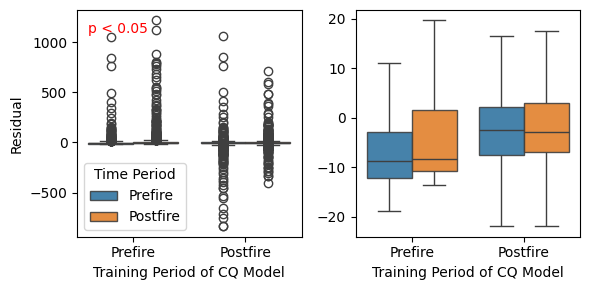

In [24]:
# Create boxplot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 3), sharex=True)
ax1 = sns.boxplot(data = resdl_long[(resdl_long['CQmodel Type'] == 'Residual_mix_precal') | (resdl_long['CQmodel Type'] == 'Residual_mix_postcal')], x = 'CQmodel Type', \
            y='Residual', hue = 'Time Period', legend=True, boxprops=dict(alpha=0.9), showfliers=True, ax = axes[0])
ax2 = sns.boxplot(data = resdl_long[(resdl_long['CQmodel Type'] == 'Residual_mix_precal') | (resdl_long['CQmodel Type'] == 'Residual_mix_postcal')], x = 'CQmodel Type', \
            y='Residual', hue = 'Time Period', legend=False, boxprops=dict(alpha=0.9), showfliers=False, ax = axes[1])
ax1.set_xlabel('Training Period of CQ Model')
ax2.set_xlabel('Training Period of CQ Model')
# plt.xticks(['Residual_mix_precal'])
plt.xticks(ticks=['Residual_mix_precal', 'Residual_mix_postcal'], \
           labels=['Prefire', 'Postfire']) # , 'Residual_mix_fullcal', 'Full Period'
ax2.set_ylabel('')
# Adjust the horizontal space between the subplots
# plt.suptitle('Observation - Model', y=0.95)
ax1.text(0.05, 0.90, 'p < 0.05', fontdict={'color':'red'}, transform=ax1.transAxes)
plt.subplots_adjust(wspace=0.001)
plt.tight_layout()
# plt.savefig(f'{fig_dir}Residual_mix_model.png', format = 'png', dpi=300)

### 4-5 Plot the distribution of CVc/CVq

C:\Users\QianW\AppData\Local\Temp\ipykernel_23196\1342462813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_df_sel.loc[(cv_df_sel['stormID'] <= 50), 'period'] = 'Prefire'


Text(0.5, 0, 'Time Period')

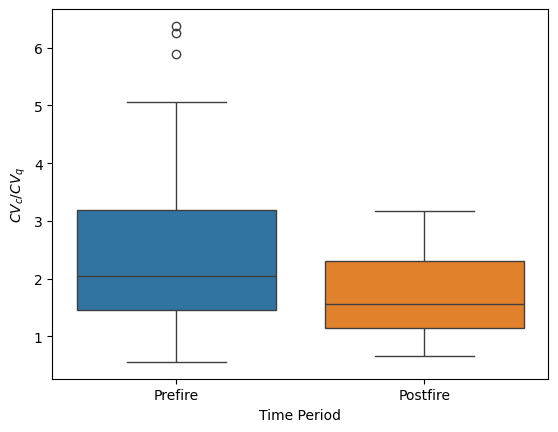

In [86]:
storm_ID_use = storm_data.stormID.values
end_pre_stormID = 50
cv_df_sel = cv_df[cv_df['stormID'].isin(storm_ID_use)]
cv_df_sel.loc[(cv_df_sel['stormID'] <= 50), 'period'] = 'Prefire'
cv_df_sel.loc[(cv_df_sel['stormID'] > end_pre_stormID), 'period'] = 'Postfire'
sns.boxplot(data=cv_df_sel, x='period', y = 'cvcq_total', hue='period')
plt.ylabel(r'$CV_c/CV_q$')
plt.xlabel('Time Period')
# plt.savefig(f'{fig_dir}CV_Flow_Turb.png')

### 4-6 Scatter plot of calculated Turbidity

In [60]:
import matplotlib.cm as cm
lab_fs = 10
tick_fs = 10

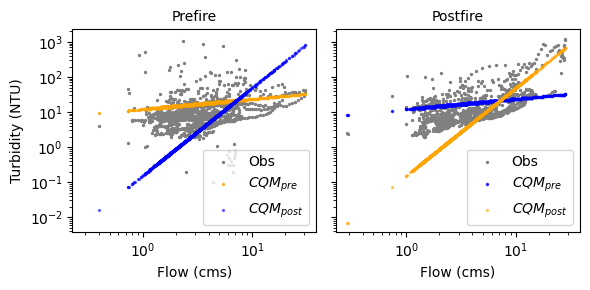

In [88]:
# Plot 2: Scatter plot of turbidity
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(6, 3))
# Using gradient colors for data one year before fire
predata = storm_data[storm_data['Time Period'] == 'Prefire']

# Plot the observed data.
scatter_pre = axes[0].scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = 'grey', label = 'Obs')
axes[0].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'orange', alpha = 0.8) 
axes[0].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'blue', alpha = 0.5)  
# axes[0].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Fullcal'].values, s = 2,
#         label=r'$CQM_{full}$', color = 'purple', alpha = 0.3) 

axes[0].set_title('Observation', fontsize = lab_fs)
axes[0].set_title('Prefire', fontsize = lab_fs)
axes[0].tick_params(axis='both', which = 'major', labelsize = tick_fs)
# Add the color bar

# Settings for the figure for postfire
postdata = storm_data[storm_data['Time Period'] == 'Postfire']
# Plot the observed data.
scatter_pre = axes[1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = 'grey', label = 'Obs')
axes[1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'blue', alpha = 0.8) 
axes[1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'orange', alpha = 0.5)  
# axes[ 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Fullcal'].values, s = 2,
#         label=r'$CQM_{full}$', color = 'purple', alpha = 0.3) 
plt.xscale('log')
plt.yscale('log')
axes[1].set_title('Postfire', fontsize = lab_fs)
# Set figure legend
for ii in range(2):
    axes[ii].legend(fontsize = lab_fs)
    # axes[ii, 1].legend(title = 'Model Type', fontsize = lab_fs)
    axes[ii].set_xlabel('Flow (cms)', fontsize = lab_fs)
# Set xaxis and y-axis label
axes[0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
plt.subplots_adjust(hspace=0.1)
# Save figure
plt.tight_layout()
# plt.savefig(f'{fig_dir}calCQFit.png', format='png', dpi=300)

In [ ]:
# Import CQ model and calculate the simulation as a line instead of separated dots
from functions import CQModel
storm_intp = np.linspace(storm_data.loc[:, 'Discharge (cms)'].min(), storm_data.loc[:, 'Discharge (cms)'].max(), 1000)
flow_intp = np.zeros(shape=(len(storm_intp), 3))
flow_intp[:, 0] = storm_intp
tbdt_est_full = CQModel(mod_type='mixed').evaluate(flow_intp, [1.57, 0.41])
tbdt_est_pre = CQModel(mod_type='mixed').evaluate(flow_intp, [1.96, 0.08])
tbdt_est_post = CQModel(mod_type='mixed').evaluate(flow_intp, [1.35, 0.53])

C:\Users\u1066632\AppData\Local\Temp\ipykernel_20392\3487390002.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


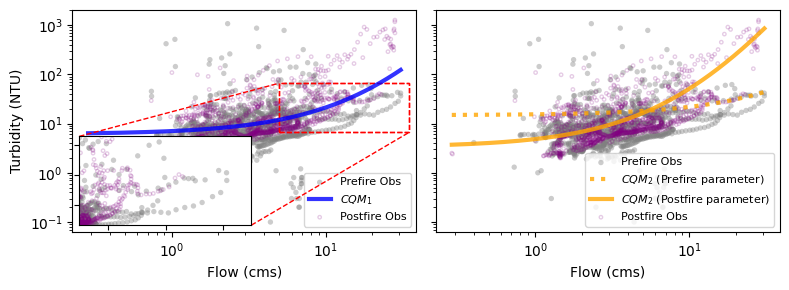

In [129]:
# Plot 2: Scatter plot of turbidity
import matplotlib.patches as patches

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 3))
# Using gradient colors for data one year before fire
predata = storm_data[storm_data['Time Period'] == 'Prefire']
# Plot the observed data.
scatter_pre = axes[0].scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                            marker = 'o', s = 15, edgecolor = 'none', facecolors='grey', label = 'Prefire Obs', alpha=0.4)
axes[0].plot(storm_intp, tbdt_est_full, linewidth = 3, label=r'$CQM_{1}$', color = 'blue', alpha = 0.8) 
axes[0].tick_params(axis='both', which = 'major', labelsize = tick_fs)
# Settings for the figure for postfire
postdata = storm_data[storm_data['Time Period'] == 'Postfire']
# Plot the observed data.
scatter_pre = axes[0].scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 6, facecolors='none', edgecolors='purple', label = 'Postfire Obs', alpha = 0.2)

# Define the rectangle (x, y, width, height)
rect = patches.Rectangle(
    (0.6, 0.45),  # Bottom-left corner
    0.38, 0.22,  # Width and height of the box
    linewidth=1,  # Thickness of the border
    edgecolor='red',  # Border color
    linestyle='--',  # Dashed line
    facecolor='none',  # No fill color
    transform = axes[0].transAxes
)
# Add the rectangle to your existing axes
axes[0].add_patch(rect)


## ============================plot results for CQM_2============================##
predata = storm_data[storm_data['Time Period'] == 'Prefire']
# Plot the observed data.
scatter_pre = axes[1].scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                            marker = 'o', s = 15, edgecolor = 'none', facecolors='grey', label = 'Prefire Obs', alpha=0.4)
axes[1].plot(storm_intp, tbdt_est_pre, linewidth = 3, label=r'$CQM_{2}$ (Prefire parameter)', color = 'orange', ls= ':', alpha = 0.8) 
axes[1].plot(storm_intp, tbdt_est_post, linewidth = 3, label=r'$CQM_{2}$ (Postfire parameter)', color = 'orange', alpha = 0.8) 
axes[1].tick_params(axis='both', which = 'major', labelsize = tick_fs)
# Settings for the figure for postfire
postdata = storm_data[storm_data['Time Period'] == 'Postfire']
# Plot the observed data.
scatter_pre = axes[1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 6, facecolors='none', edgecolors='purple', label = 'Postfire Obs', alpha = 0.2)

plt.xscale('log')
plt.yscale('log')
# Set figure legend
axes[0].legend(fontsize = 8, loc = 'lower right')
axes[1].legend(fontsize = 8, loc = 'lower right')
axes[0].set_xlabel('Flow (cms)', fontsize = lab_fs)
axes[1].set_xlabel('Flow (cms)', fontsize = lab_fs)
# Set xaxis and y-axis label
axes[0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
plt.subplots_adjust(hspace=0.1)
## Insert zoom in subplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# Get data coordinates of the rectangle corners
(x0, y0) = axes[0].transAxes.transform((0.6, 0.45))
(x1, y1) = axes[0].transAxes.transform((0.98, 0.67))

# Convert pixel coords back into data coords
(x0_data, y0_data) = axes[0].transData.inverted().transform((x0, y0))
(x1_data, y1_data) = axes[0].transData.inverted().transform((x1, y1))

# Create inset zoom
axins = inset_axes(axes[0], width="50%", height="40%", loc='lower left')

axins.scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                            marker = 'o', s = 15, edgecolor = 'none', facecolors='grey', label = 'Prefire Obs', alpha=0.4)
axins.scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 6, facecolors='none', edgecolors='purple', label = 'Postfire Obs', alpha = 0.2)

# Set zoom limits matching red box
axins.set_xlim(x0_data, x1_data)
axins.set_ylim(y0_data, y1_data)

# Draw the connection lines
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="red", ls='--')
axins.tick_params(
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
) 
# Save figure
plt.tight_layout()
plt.savefig(f'{fig_dir}calCQFit.png', format='png', dpi=300)

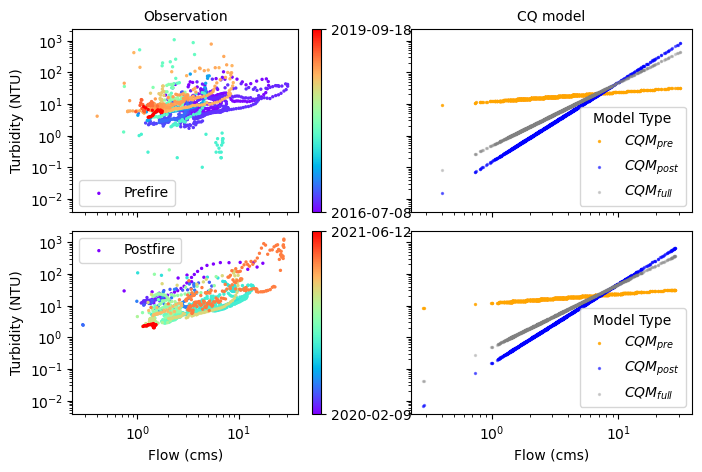

In [91]:
# Plot 2: Scatter plot of turbidity
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(8, 5))
# Using gradient colors for data one year before fire
predata = storm_data[storm_data['Time Period'] == 'Prefire']
date_nums = predata.Datetime.astype(np.int64) // 1e9
norm = plt.Normalize(date_nums.min(), date_nums.max())
colors = cm.rainbow(norm(date_nums)) 
sm = cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
sm.set_array([])  # Required for the ScalarMappable object

# Plot the observed data.
scatter_pre = axes[0, 0].scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = colors, label = 'Prefire')
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'orange', alpha = 0.8) 
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'blue', alpha = 0.5)  
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Fullcal'].values, s = 2,
        label=r'$CQM_{full}$', color = 'grey', alpha = 0.3) 

#Add color bars
axes[0, 0].set_title('Observation', fontsize = lab_fs)
axes[0, 1].set_title('CQ model', fontsize = lab_fs)
axes[0, 1].tick_params(axis='both', which = 'major', labelsize = tick_fs)
# Add the color bar
# cbar = plt.colorbar(scatter_pre)
cbar = fig.colorbar(sm, ax=axes[0, 0])
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.set_ticklabels([(str(predata.Datetime.values[0])[:10]), str(predata.Datetime.values[-1])[:10]])

# Settings for the figure for postfire
postdata = storm_data[storm_data['Time Period'] == 'Postfire']
date_nums = postdata.Datetime.astype(np.int64) // 1e9
norm_post = plt.Normalize(date_nums.min(), date_nums.max())
colors = cm.rainbow(norm_post(date_nums)) 
sm = cm.ScalarMappable(cmap=cm.rainbow, norm=norm_post)
sm.set_array([])  # Required for the ScalarMappable object

# Plot the observed data.
scatter_pre = axes[1, 0].scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = colors, label = 'Postfire')
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'orange', alpha = 0.8) 
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'blue', alpha = 0.5)  
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Fullcal'].values, s = 2,
        label=r'$CQM_{full}$', color = 'grey', alpha = 0.3) 
plt.xscale('log')
plt.yscale('log')
# Set figure legend
for ii in range(2):
    for jj in range(2):
        axes[ii, jj].legend(fontsize = lab_fs)
    axes[ii, 1].legend(title = 'Model Type', fontsize = lab_fs)
    axes[1, ii].set_xlabel('Flow (cms)', fontsize = lab_fs)
#Add color bars
# cbar = plt.colorbar(scatter_pre)
cbar = fig.colorbar(sm, ax=axes[1, 0])
cbar.set_ticks([norm_post.vmin, norm_post.vmax])
cbar.set_ticklabels([(str(postdata.Datetime.values[0])[:10]), str(postdata.Datetime.values[-1])[:10]])
# Set xaxis and y-axis label
axes[0, 0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
axes[1, 0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
plt.subplots_adjust(hspace=0.1)
# Save figure
plt.savefig(f'{fig_dir}calCQFit.png', format='png', dpi=300)

## Calculate whether coefficients are significantly different

In [65]:
# Regression coefficients of different models
mean_coeff = np.array([[1.96, 1.35, 1.57], [0.08, 0.53, 0.41]])
std_coeff = np.array([[0.26, 0.27, 0.23], [0.18, 0.11, 0.10]])
from scipy.stats import t
t_value = (mean_coeff[1][0] - mean_coeff[1][1]) / (std_coeff[1][0]**2 + std_coeff[1][1]**2)**0.5
# 自由度（近似）
df = storm_data.shape[0]  - 4 # 根据样本大小调整
p_value = 2 * (1 - t.cdf(abs(t_value), df=df))

print(f"T-value: {t_value}, P-value: {p_value}")
if p_value <= 0.05:
    print('There is significant difference in coefficient b for models fitted by pre- and post-fire data')
# compare coefficients prefire and full models
t_value = (mean_coeff[1][0] - mean_coeff[1][2]) / (std_coeff[1][0]**2 + std_coeff[1][2]**2)**0.5
# 自由度（近似）
df = storm_data.shape[0]  - 4 # 根据样本大小调整
p_value = 2 * (1 - t.cdf(abs(t_value), df=df))

print(f"T-value: {t_value}, P-value: {p_value}")
if p_value <= 0.05:
    print('There is significant difference in coefficient b for models fitted by pre-fire and full data')

T-value: -2.1332045841298974, P-value: 0.033016055821176504
There is significant difference in coefficient b for models fitted by pre- and post-fire data
T-value: -1.6026216728894858, P-value: 0.1091588199996274


## Plot Cross-Correlation Function of turbidity and flow 

In [26]:
# Read data
fn = '../output/CQ_analysis/212058/cross_WQ.xlsx'
df = pd.read_excel(fn, usecols=[2, 4, 17])
df.columns = ['lag', 'Postfire CCF', 'Prefire CCF']

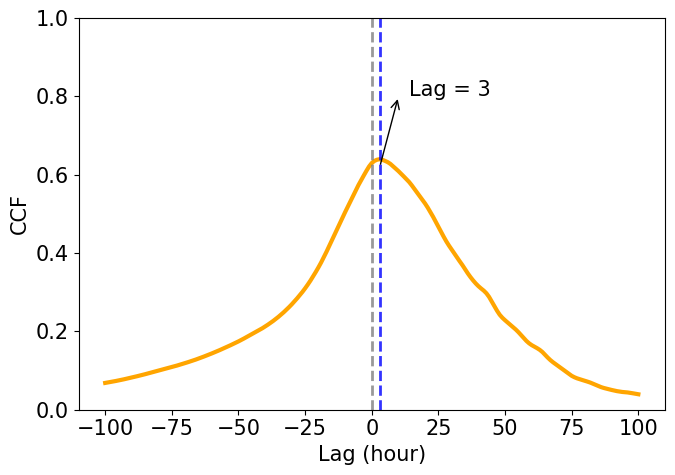

In [35]:
# Plot CCF
df_slice = df[(df['lag'] >= -100) & (df['lag'] <= 100)]
fig = plt.figure(figsize=(7, 5))
plt.rcParams.update({
    'font.size':        15,               # 控制默认文本大小
    'axes.titlesize':   15,          # 坐标轴标题大小
    'axes.labelsize':   15,          # 坐标轴标签大小
    'xtick.labelsize':  15,         # x轴刻度标签大小
    'ytick.labelsize':  15,         # y轴刻度标签大小
    'legend.fontsize':  15,         # 图例字体大小
    'figure.titlesize': 15         # 图形总标题大小
})
# ax = sns.lineplot(data = df_slice, x = 'lag', y = 'Prefire CCF', color = 'blue', label = 'Prefire')
ax = sns.lineplot(data = df_slice, x = 'lag', y = 'Postfire CCF', color = 'orange', lw = 3)
ax.set_ylim(0, 1)
ax.vlines(0, 0, 1, linestyles='--', lw = 2, color = 'grey', alpha = 0.8)
ax.vlines(3, 0, 1, linestyles='--', lw = 2, color = 'blue', alpha = 0.8)
ax.annotate("", xy=(10, 0.8), xytext=(3, 0.62),
            arrowprops=dict(arrowstyle="->"), alpha = 0.8)
ax.text(14, 0.8, 'Lag = 3')
ax.set_ylabel('CCF')
ax.set_xlabel('Lag (hour)')
ax.tick_params('both')
plt.tight_layout()
plt.savefig('../output/figs/212058/CCF_postfire.png', dpi = 300, format = 'png')

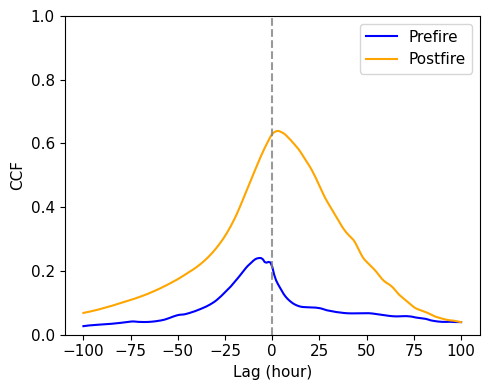

In [ ]:
# Plot CCF
df_slice = df[(df['lag'] >= -100) & (df['lag'] <= 100)]
fig = plt.figure(figsize=(5, 4))
ax = sns.lineplot(data = df_slice, x = 'lag', y = 'Prefire CCF', color = 'blue', label = 'Prefire')
sns.lineplot(data = df_slice, x = 'lag', y = 'Postfire CCF', color = 'orange', label = 'Postfire')
ax.set_ylim(0, 1)
ax.vlines(0, 0, 1, linestyles='--', color = 'grey', alpha = 0.8)
ax.set_ylabel('CCF', fontsize = 11)
ax.set_xlabel('Lag (hour)', fontsize = 11)
ax.tick_params('both', labelsize = 11)
ax.legend(fontsize = 11)
plt.tight_layout()
plt.savefig('../output/figs/212058/CCF.png', dpi = 300, format = 'png')